# Bibliotecas

In [19]:
from sweepcircles import *
from scipy.spatial import Delaunay, delaunay_plot_2d
from scipy.spatial import Delaunay, distance_matrix
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Circle as CirclePatch

# Datos

In [20]:
# Ruta al archivo
file_path = "../data/Towns_HB_2024-08-14.xlsx"

# Leer todas las hojas como un diccionario {nombre_hoja: DataFrame}
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Filtrar solo las hojas que tienen datos (al menos una fila no vacía)
non_empty_sheets = {name: df for name, df in all_sheets.items() if not df.dropna(how='all').empty}

# Mostrar nombres de hojas con datos
print(f"Hojas con datos: {list(non_empty_sheets.keys())}")

df_towns = non_empty_sheets["Towns"]
df_triple_alliance = non_empty_sheets["Triple Alliance towns"]
df_tenochtitlan = non_empty_sheets["Tenochtitlan"]
df_zempoala = non_empty_sheets["Zempoala"]
df_79 = non_empty_sheets["79 Destinations"]
df_tecpilpan = non_empty_sheets["Tecpilpan"]

Hojas con datos: ['Towns', 'Triple Alliance towns', 'Tenochtitlan', 'Zempoala', '79 Destinations', 'Tecpilpan']


In [30]:
coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values
len(coords)

80

# Funciones Auxiliares

## Create Lunes

In [22]:
from typing import Tuple, Union
import math

Point = Tuple[float, float]
Weight = Union[float, Tuple[float, float]]

def create_lunes(p1: Point, p2: Point, beta: float, weight: Weight = 0.0):
    """
    Build two circles ("lunes") based on two input points, a β parameter, and a weight.

    Parameters
    ----------
    p1 : (float, float)
        First point (x1, y1).
    p2 : (float, float)
        Second point (x2, y2).
    beta : float
        β parameter (> 0). Controls the base radius magnitude relative to the
        distance between p1 and p2.
    weight : float | (float, float), optional (default=0.0)
        Longitudinal offsets applied along the line p1→p2:
        - If a single float, the same offset is used for both points: w1 = w2 = weight.
        - If a 2-tuple (w1, w2), use w1 for the shift from p1 and w2 for the shift from p2.

    Geometry & Formulas
    -------------------
    Let d = ||p2 - p1|| (Euclidean distance) and u = (p2 - p1) / d (unit direction p1→p2).

    The (weighted) radius is:
        r = (β * d) / 2  -  (w1 + w2) / 2

    The circle centers are shifted ALONG the line joining the points:
        c1 = p1 + (r + w1) * u        # from p1 toward p2
        c2 = p2 - (r + w2) * u        # from p2 toward p1

    Returns
    -------
    list[ ((float, float), float), ((float, float), float) ]
        A list with two circles:
          [ (c1, r), (c2, r) ]
        where c1 and c2 are (x, y) centers and r is the (shared) radius.

    Raises
    ------
    ValueError
        If beta <= 0, or if p1 == p2 (distance zero),
        or if `weight` is a tuple of length != 2.

    Notes
    -----
    - Weights modify the effective radius **only through** the chosen formula above,
      and also shift the centers by (r + wi) along the line p1↔p2. They do not
      create any perpendicular offsets.
    - For an unweighted variant, set weight = 0.0 (or (0.0, 0.0)), which yields
      r = (β * d) / 2 and centers at distance r from each point along the line.
    """
    # Guard on β
    if beta <= 0:
        raise ValueError("beta must be > 0.")

    # Vector from p1 to p2 and its length
    (x1, y1), (x2, y2) = p1, p2
    dx, dy = x2 - x1, y2 - y1
    d = math.hypot(dx, dy)
    if d == 0:
        raise ValueError("p1 and p2 must be distinct points.")

    # Unit vector u in the direction p1 -> p2
    ux, uy = dx / d, dy / d

    # Normalize weights to (w1, w2)
    if isinstance(weight, tuple):
        if len(weight) != 2:
            raise ValueError("weight tuple must be (w1, w2).")
        w1, w2 = float(weight[0]), float(weight[1])
    else:
        w1 = w2 = float(weight)

    # Weighted radius per your chosen convention:
    # r = 0.5 * β * d - (w1 + w2)/2
    r = 0.5 * beta * d - (w1 + w2) / 2.0

    # Centers shifted ALONG the line by (r + wi)
    c1 = (x1 + (r + w1) * ux, y1 + (r + w1) * uy)  # from p1 toward p2
    c2 = (x2 - (r + w2) * ux, y2 - (r + w2) * uy)  # from p2 toward p1

    # Return the two circles with the shared radius r
    return [(c1, r), (c2, r)]


In [23]:
p1 = (0.0, 0.0)
p2 = (3.0, 4.0)   # distance 5
points = [p1, p2]
beta = 1.0
weight = (2.0, 1.5)      # or (2.0, 1.0) if you want different weights
circles = list(create_lunes(p1, p2, beta, weight))
circles.extend([(p1, weight[0]), (p2, weight[1])])
print(circles)

[((1.65, 2.2), 0.75), ((1.6500000000000001, 2.2), 0.75), ((0.0, 0.0), 2.0), ((3.0, 4.0), 1.5)]


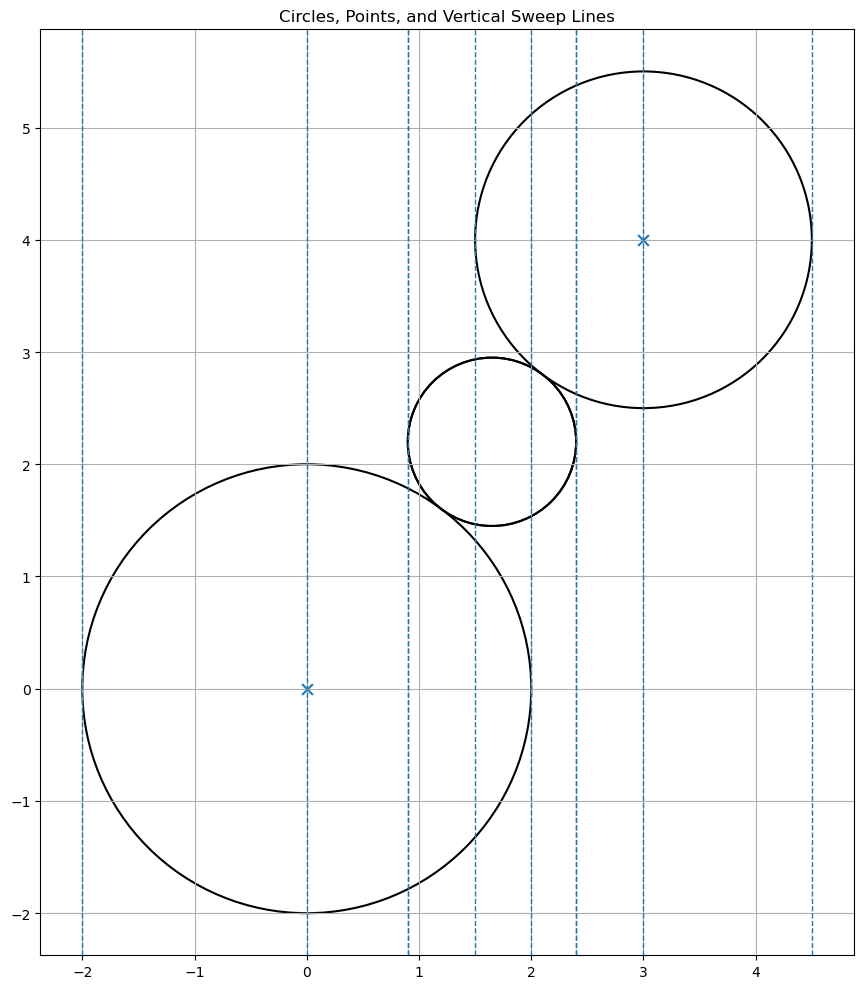

In [24]:
def plot_circles_points_with_verticals(circles, points, figsize=(7, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    # Collect verticals: points' x and circle endpoints (cx±r)
    vxs = set(x for x, _ in points)
    for (cx, cy), r in circles:
        vxs.add(cx - r)
        vxs.add(cx + r)

    # Circles
    for ((cx, cy), r) in circles:
        ax.add_patch(CirclePatch((cx, cy), r, fill=False, linewidth=1.5))

    # Points
    if points:
        px, py = zip(*points)
        ax.scatter(px, py, marker="x", s=60, linewidths=1.5)

    # Dashed verticals
    for x in sorted(vxs):
        ax.axvline(x, linestyle="--", linewidth=1)

    # Bounds
    xs = list(px) + [cx - r for (cx, cy), r in circles] + [cx + r for (cx, cy), r in circles] if points else \
         [cx - r for (cx, cy), r in circles] + [cx + r for (cx, cy), r in circles]
    ys = list(py) + [cy - r for (cx, cy), r in circles] + [cy + r for (cx, cy), r in circles] if points else \
         [cy - r for (cx, cy), r in circles] + [cy + r for (cx, cy), r in circles]

    if xs and ys:
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        pad = 0.05 * max(xmax - xmin, ymax - ymin) or 1.0
        ax.set_xlim(xmin - pad, xmax + pad)
        ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Circles, Points, and Vertical Sweep Lines")
    ax.grid(True)
    fig.tight_layout()
    plt.show()

# Example call:
plot_circles_points_with_verticals(circles, points, figsize=(12, 10))


# Delaunay

In [25]:
Delaunay(coords)

<Figure size 1000x1000 with 0 Axes>

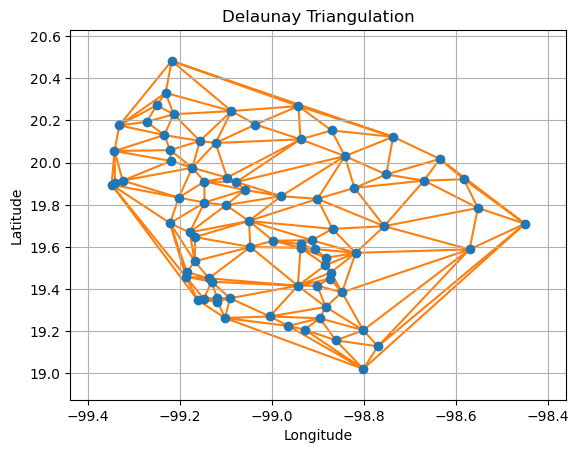

In [26]:
plt.figure(figsize=(10, 10))
delaunay_plot_2d(Delaunay(coords))
plt.title("Delaunay Triangulation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [27]:
# import numpy as np
# from scipy.spatial import Delaunay

# def delaunay_adjacency(coords, return_edges=False, joggle=False):
#     """
#     Return an n×n boolean adjacency matrix A where A[i,j] = True
#     iff points i and j share a Delaunay edge. Optionally returns the edge list.

#     Params
#     ------
#     coords : (n, d) array-like
#         Point coordinates (usually d=2).
#     return_edges : bool
#         If True, also return a (m, 2) array of undirected edges (i < j).
#     joggle : bool
#         If True, pass Qhull option 'QJ' to slightly joggle input to avoid
#         degeneracy errors on collinear/near-collinear inputs.

#     Returns
#     -------
#     A : (n, n) np.ndarray (bool)
#     edges : (m, 2) np.ndarray (int), only if return_edges=True
#     """
#     coords = np.asarray(coords)
#     opts = 'QJ' if joggle else None
#     tri = Delaunay(coords, qhull_options=opts)

#     # Triangles as vertex indices (m, 3)
#     T = tri.simplices

#     # Collect undirected edges from each triangle: (i,j), (j,k), (k,i)
#     E = np.vstack([T[:, [0, 1]], T[:, [1, 2]], T[:, [2, 0]]])

#     # Make edges undirected and unique
#     E.sort(axis=1)                     # ensure i < j per row
#     E = np.unique(E, axis=0)

#     n = len(coords)
#     A = np.zeros((n, n), dtype=bool)
#     A[E[:, 0], E[:, 1]] = True
#     A[E[:, 1], E[:, 0]] = True

#     return (A, E) if return_edges else A


[((-98.88328200000001, 19.12357), 0.13057038013270927), ((-98.88328200000001, 19.12357), 0.13057038013270927), ((-98.80162, 19.021688), 0.0), ((-98.964944, 19.225452), 0.0)]


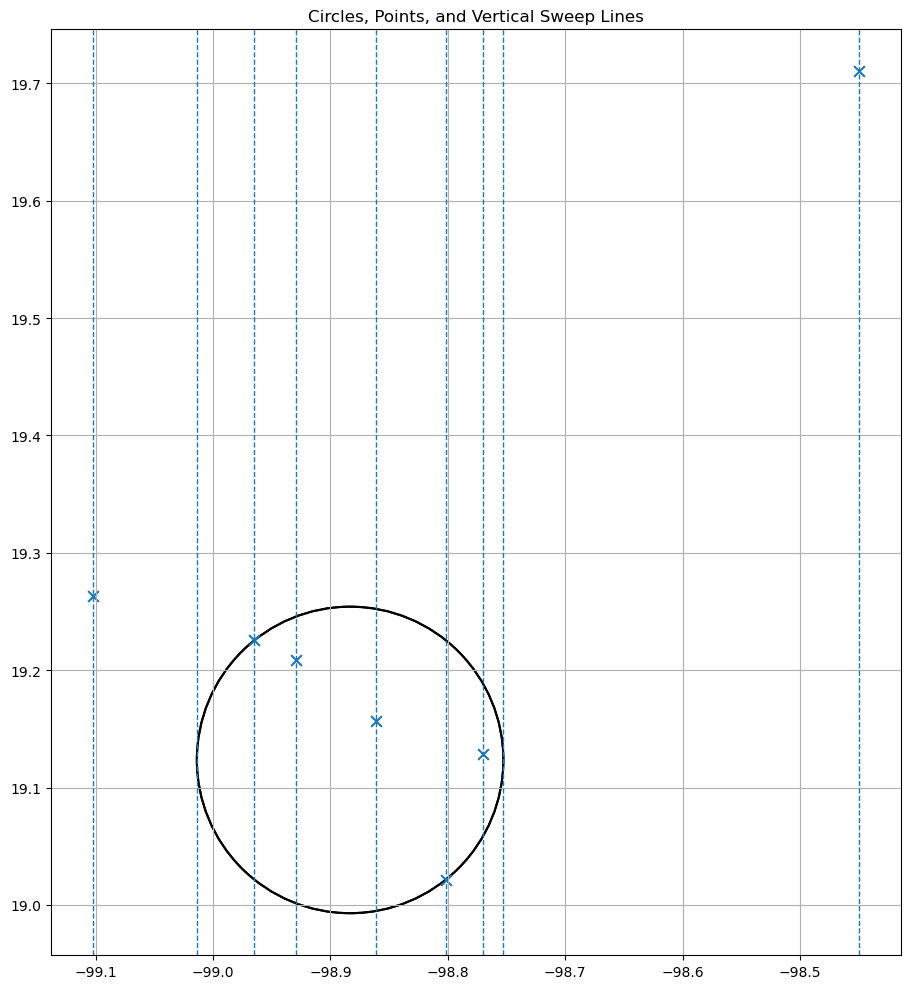

In [49]:
import numpy as np
from scipy.spatial import Delaunay

def compute_delaunay(coords: np.ndarray) -> np.ndarray:
    """
    Return Delaunay edges as a (m,2) int array with i<j and no duplicates.
    """
    tri = Delaunay(coords)
    T = tri.simplices  # (k,3)

    # Collect all triangle edges
    E = np.vstack([T[:, [0, 1]], T[:, [1, 2]], T[:, [2, 0]]])
    E.sort(axis=1)                      # make undirected: i<j per row
    E = np.unique(E, axis=0)            # remove duplicates
    return E

# def circles_from_delaunay_edge(coords: np.ndarray, edges: np.ndarray, k: int, beta: float, weight=(0.0, 0.0)):
#     """
#     Take the k-th Delaunay edge and construct its two lunes (your create_lunes),
#     plus the two extra circles centered at the endpoints with radii = weight entries.
#     """
#     i, j = edges[k]
#     p1, p2 = tuple(coords[i]), tuple(coords[j])
#     circles = list(create_lunes(p1, p2, beta=beta, weight=weight))
#     circles.extend([(p1, float(weight[0])), (p2, float(weight[1]))])
#     return circles

# delaunay_edges = compute_delaunay(coords)
# delaunay_edges[0]

import numpy as np

def neighbors_of_node(edges: np.ndarray, node: int = 0):
    """
    From an (m,2) edges array with i<j, return:
      - incident_edges: all edges that touch `node`
      - neighbor_ids: the other endpoint of each such edge (unique)
    """
    mask = (edges[:, 0] == node) | (edges[:, 1] == node)
    incident_edges = edges[mask]
    neighbor_ids = np.where(incident_edges[:, 0] == node, incident_edges[:, 1], incident_edges[:, 0])
    neighbor_ids = np.unique(neighbor_ids)
    return incident_edges, neighbor_ids

# --- usage ---
edges = compute_delaunay(coords)        # (m, 2) with i<j
incident_edges, nbr_ids = neighbors_of_node(edges, node=0)

# Points = all tuples that share an edge with node 0 (include node 0 too)
points = [tuple(coords[0])] + [tuple(coords[i]) for i in nbr_ids]

# If you only want the *neighbors* (excluding 0), then:
# points = [tuple(coords[i]) for i in nbr_ids]

# Example: build circles for the first incident edge with 0
if len(incident_edges):
    i, j = incident_edges[2]
    p1, p2 = tuple(coords[i]), tuple(coords[j])
    beta = 1.0
    weight = (0.0, 0.0)
    circles = list(create_lunes(p1, p2, beta, weight))
    circles.extend([(p1, weight[0]), (p2, weight[1])])

    # Plot with your helper
    # plot_circles_points_with_verticals(circles, points, figsize=(12, 10))

# edges = compute_delaunay(coords)
# i, j = edges[0]
# p1, p2 = tuple(coords[i]), tuple(coords[j])
# points = [p1, p2]
# circles = list(create_lunes(p1, p2, beta=2.0, weight=(0.0, 0.0)))
# circles.extend([(p1, 0.0), (p2, 0.0)])
print(circles)
plot_circles_points_with_verticals(circles, points, figsize=(12, 10))

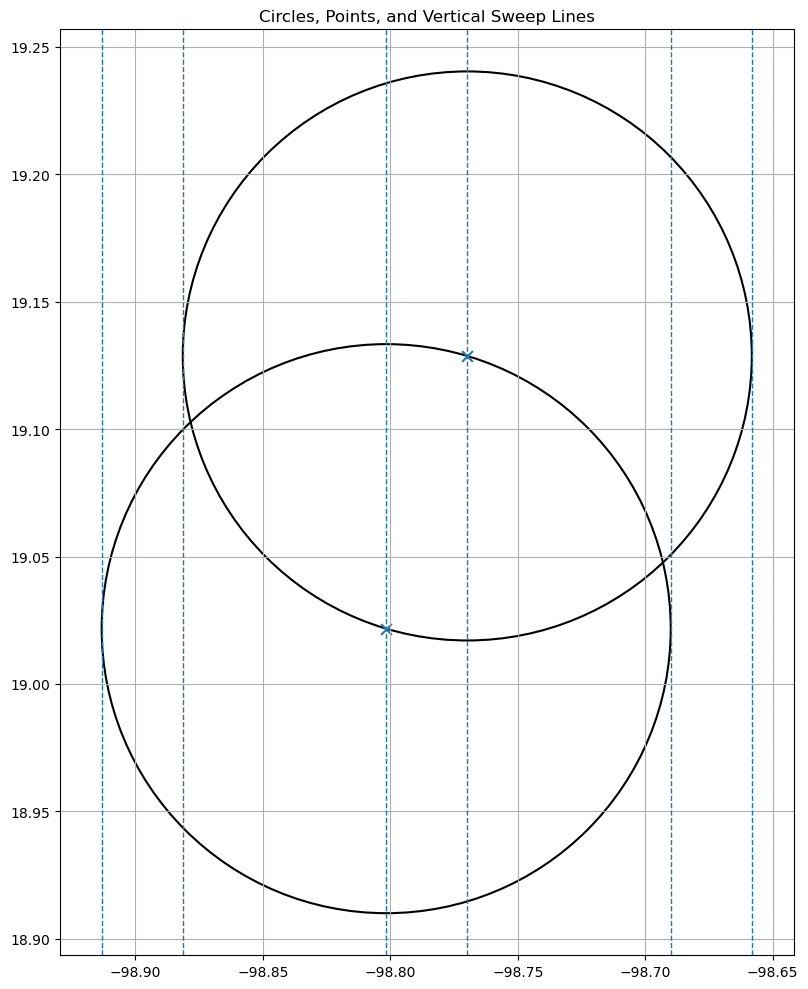

In [45]:
import numpy as np

# 1) Clean rows with missing Longitude/Latitude
# df_towns_clean = df_towns[['Longitude', 'Latitude', 'Toponym']].dropna()

# # 2) Build coords array and points list (x = Longitude, y = Latitude)
# coords = df_towns_clean[['Longitude', 'Latitude']].to_numpy(dtype=float)
# points = list(map(tuple, coords))            # <- this is what the plot() needs
# names  = df_towns_clean['Toponym'].tolist()  # optional labels aligned with points

plot_circles_points_with_verticals(circles, points, figsize=(12, 10))

In [41]:
edges

array([[ 0,  1],
       [ 0,  2],
       [ 0,  5],
       [ 0,  7],
       [ 0, 40],
       [ 0, 76],
       [ 1,  2],
       [ 1,  3],
       [ 1, 27],
       [ 1, 40],
       [ 2,  3],
       [ 2,  4],
       [ 2, 76],
       [ 3,  4],
       [ 3,  8],
       [ 3, 14],
       [ 3, 27],
       [ 4,  5],
       [ 4,  6],
       [ 4,  8],
       [ 4, 76],
       [ 5,  6],
       [ 5,  7],
       [ 5, 76],
       [ 6,  7],
       [ 6,  8],
       [ 6, 13],
       [ 6, 16],
       [ 7,  9],
       [ 7, 10],
       [ 7, 13],
       [ 8, 14],
       [ 8, 15],
       [ 8, 16],
       [ 9, 10],
       [ 9, 11],
       [ 9, 12],
       [ 9, 13],
       [10, 11],
       [10, 19],
       [10, 49],
       [11, 12],
       [11, 17],
       [11, 19],
       [12, 13],
       [12, 17],
       [13, 16],
       [13, 17],
       [14, 15],
       [14, 22],
       [14, 23],
       [14, 26],
       [14, 27],
       [15, 16],
       [15, 22],
       [16, 17],
       [16, 18],
       [16, 22],
       [16, 23

In [16]:
# A, edges = delaunay_adjacency(coords, return_edges=True)
# print(A.astype(int))   # 1s where points are connected
# # print(edges)           # pairs (i < j) that form Delaunay edges

[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Esto es simétrico sólo debo revisar los 1 del triángulo superior
# pensar si puedo evaluar de dos en dos
# o renglón por renglón

## Complete graph

In [ ]:
# Si acá son todos contra todos, cómo le hago para reducir?????

# Algoritmo completo